# Connection to BCM database

In [27]:
import matplotlib.pyplot as plt
import math

import datajoint as dj
dj.config['database.host'] = 'at-database.ad.bcm.edu:3306'

dj.conn()

#define the external storage
dj.config['stores'] = {
  'minio': dict( # 'raw' storage for this pipeline
                protocol='file',
                location='/mnt/dj-stor01/users/maria/mouse_neuropixels_meis') #'cifs://at-storage5.ad.bcm.edu/dj-stor01/users/maria/''
}

dj.config["enable_python_native_blobs"] = True
dj.config['nnfabrik.schema_name'] = 'mouse_neuropixels_meis'
dj.config['mei.schema_name'] = 'mouse_neuropixels_meis'

from sensorium.schemas import schema, Fabrikant, Dataset, Model, Trainer, Seed, TrainedModel, MEISeed, MEIMethod, MEISelector, TrainedEnsembleModel, MEI
from sensorium.schemas.scores import CorrelationToAverage, ValidationCorrelationToSingle


imagenet = dj.create_virtual_module('imagenet.py', 'pipeline_imagenet')
stim = dj.create_virtual_module('stimulus.py', 'pipeline_stimulus')
mov = dj.create_virtual_module('netflix.py', 'pipeline_netflix') 
experiment = dj.create_virtual_module('exp.py', 'pipeline_experiment')
acq = dj.create_virtual_module('acq','acq')

In [28]:
imagenet.Album.Oracle() & imagenet.TargetAlbumNpx()

collection_id image collection id,image_class,image_id image id
7,imagenet,104
7,imagenet,128
7,imagenet,183
7,imagenet,355
7,imagenet,479
7,imagenet,483
7,imagenet,656
7,imagenet,803
7,imagenet,830
7,imagenet,936


# Connection to local DB where MEIs are in

In [29]:
from matplotlib import pyplot as plt

import torch
from torch import load

import matplotlib.pyplot as plt
import numpy as np

import pickle
from tqdm import tqdm
import pandas as pd

plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

# Fetch MEIs

In [30]:
MEI()

method_fn name of the method function,method_hash hash of the method config,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,ensemble_hash the hash of the ensemble,unit_id unique neuron identifier,data_key unique session identifier,mei_seed MEI seed,mei the MEI as a tensor,score some score depending on the used method function,output object returned by the method function
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,17a917c720720314835865d32cac93f3,1a3577a497b19ae3a45a35442397cf3a,43,28470-13-1,1000,=BLOB=,2.97301,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,17a917c720720314835865d32cac93f3,1a3577a497b19ae3a45a35442397cf3a,51,28470-13-1,1000,=BLOB=,1.88006,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,17a917c720720314835865d32cac93f3,1a3577a497b19ae3a45a35442397cf3a,85,28470-13-1,1000,=BLOB=,2.29115,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,17a917c720720314835865d32cac93f3,1a3577a497b19ae3a45a35442397cf3a,102,28470-13-1,1000,=BLOB=,2.44374,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,17a917c720720314835865d32cac93f3,1a3577a497b19ae3a45a35442397cf3a,106,28470-13-1,1000,=BLOB=,2.02265,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,17a917c720720314835865d32cac93f3,1a3577a497b19ae3a45a35442397cf3a,107,28470-13-1,1000,=BLOB=,2.80873,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,17a917c720720314835865d32cac93f3,1a3577a497b19ae3a45a35442397cf3a,111,28470-13-1,1000,=BLOB=,2.33421,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,17a917c720720314835865d32cac93f3,1a3577a497b19ae3a45a35442397cf3a,116,28470-13-1,1000,=BLOB=,1.50931,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,17a917c720720314835865d32cac93f3,1a3577a497b19ae3a45a35442397cf3a,120,28470-13-1,1000,=BLOB=,2.43148,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,17a917c720720314835865d32cac93f3,1a3577a497b19ae3a45a35442397cf3a,126,28470-13-1,1000,=BLOB=,3.16019,=BLOB=


In [31]:
current_key = dict(animal_id=28470, session=13, scan_idx=1)

In [32]:
#for the SOTA model
mei_key =  dict(data_key="28470-13-1", 
                    dataset_hash="17a917c720720314835865d32cac93f3",
                    ensemble_hash = "7ea32448df4a75966d8fcd059a6eb0ae",
                    method_hash="8c7de77acabedc9479aa207d8e914e9d", 
                    mei_seed=1000)

mei_dict = (MEI & mei_key).fetch("mei", "method_hash", "ensemble_hash", "data_key", "unit_id", "dataset_hash", order_by=("unit_id", "data_key"), as_dict=True,)

len(mei_dict)

mei_paths = [i.pop("mei") for i in mei_dict]

MEIs = np.stack([torch.load(i).detach().cpu().numpy().squeeze() for i in mei_paths])

In [33]:
#for the LN model
ln_mei_key =  dict(data_key="28470-13-1", 
                    dataset_hash="17a917c720720314835865d32cac93f3",
                    ensemble_hash = "1a3577a497b19ae3a45a35442397cf3a",
                    method_hash="8c7de77acabedc9479aa207d8e914e9d", 
                    mei_seed=1000)

ln_mei_dict = (MEI & ln_mei_key).fetch("mei", "method_hash", "ensemble_hash", "data_key", "unit_id", "dataset_hash", order_by=("unit_id", "data_key"), as_dict=True,)

len(ln_mei_dict)

ln_mei_paths = [i.pop("mei") for i in ln_mei_dict]

ln_MEIs = np.stack([torch.load(i).detach().cpu().numpy().squeeze() for i in ln_mei_paths])

# Define Helper Functions

In [34]:
# the MEI itself
mei_height = 36
mei_width = 64

# dimensions of the stimulus class
frame_height = 144
frame_width = 256

# image statistics
train_mean = 114.4
train_sd =  64.3



In [35]:
from scipy import interpolate
from scipy import ndimage

z_score = np.linspace((0 - train_mean) / train_sd,(255 - train_mean) / train_sd, num=256)
px_space = np.linspace(0, 255, num=256)
z_score_to_px = interpolate.interp1d(z_score, px_space, kind='linear')

# Inserting MEIs in the StaticImage.Image table

In [8]:
stim.StaticImage.Image & {'image_class': mei_class,} 

image_class,image_id image id,image actual image
npx_mei,0,=BLOB=
npx_mei,1,=BLOB=
npx_mei,2,=BLOB=
npx_mei,3,=BLOB=
npx_mei,4,=BLOB=
npx_mei,5,=BLOB=
npx_mei,6,=BLOB=
npx_mei,7,=BLOB=
npx_mei,8,=BLOB=
npx_mei,9,=BLOB=


# Inserting Loop

In [36]:
# get image ID of the first MEI that is going to be inserted for the MEIs
mei_class = "npx_mei"
next_id = len(stim.StaticImage.Image & {'image_class': mei_class,})

for i in range(len(MEIs)):
    
    # transform MEI from z-score-space to 8-bit-space
    meis = z_score_to_px(np.clip(MEIs[i], z_score.min(), z_score.max()))
    # upsame MEIs to have the right frame size
    meis_up = ndimage.zoom(meis.astype(np.float32), (frame_height/mei_height,frame_width/mei_width), mode='reflect')
    # clipping, conversion to unit8, and inserting in the table
    stim.StaticImage.Image.insert1({'image_class': mei_class, 'image_id': next_id+i, 'image': meis_up.clip(0,255).astype(np.uint8)}, skip_duplicates=True)

    mei_dict[i]["image_id"] = next_id+i
    
stim.StaticImage.Image & {'image_class': mei_class,}

image_class,image_id image id,image actual image
npx_mei,0,=BLOB=
npx_mei,1,=BLOB=
npx_mei,2,=BLOB=
npx_mei,3,=BLOB=
npx_mei,4,=BLOB=
npx_mei,5,=BLOB=
npx_mei,6,=BLOB=
npx_mei,7,=BLOB=
npx_mei,8,=BLOB=
npx_mei,9,=BLOB=


In [37]:
# get image ID of the first MEI that is going to be inserted for the MEIs from the LN model
ln_mei_class = "npx_ln_mei"
next_id = len(stim.StaticImage.Image & {'image_class': ln_mei_class,})

for i in range(len(ln_MEIs)):
    
    # transform MEI from z-score-space to 8-bit-space
    meis = z_score_to_px(np.clip(ln_MEIs[i], z_score.min(), z_score.max()))
    # upsame MEIs to have the right frame size
    meis_up = ndimage.zoom(meis.astype(np.float32), (frame_height/mei_height,frame_width/mei_width), mode='reflect')
    # clipping, conversion to unit8, and inserting in the table
    stim.StaticImage.Image.insert1({'image_class': ln_mei_class, 'image_id': next_id+i, 'image': meis_up.clip(0,255).astype(np.uint8)}, skip_duplicates=True)

    ln_mei_dict[i]["image_id"] = next_id+i
    
stim.StaticImage.Image & {'image_class': ln_mei_class,}

image_class,image_id image id,image actual image
npx_ln_mei,0,=BLOB=
npx_ln_mei,1,=BLOB=
npx_ln_mei,2,=BLOB=
npx_ln_mei,3,=BLOB=
npx_ln_mei,4,=BLOB=
npx_ln_mei,5,=BLOB=
npx_ln_mei,6,=BLOB=
npx_ln_mei,7,=BLOB=
npx_ln_mei,8,=BLOB=
npx_ln_mei,9,=BLOB=


# Plotting the MEIs

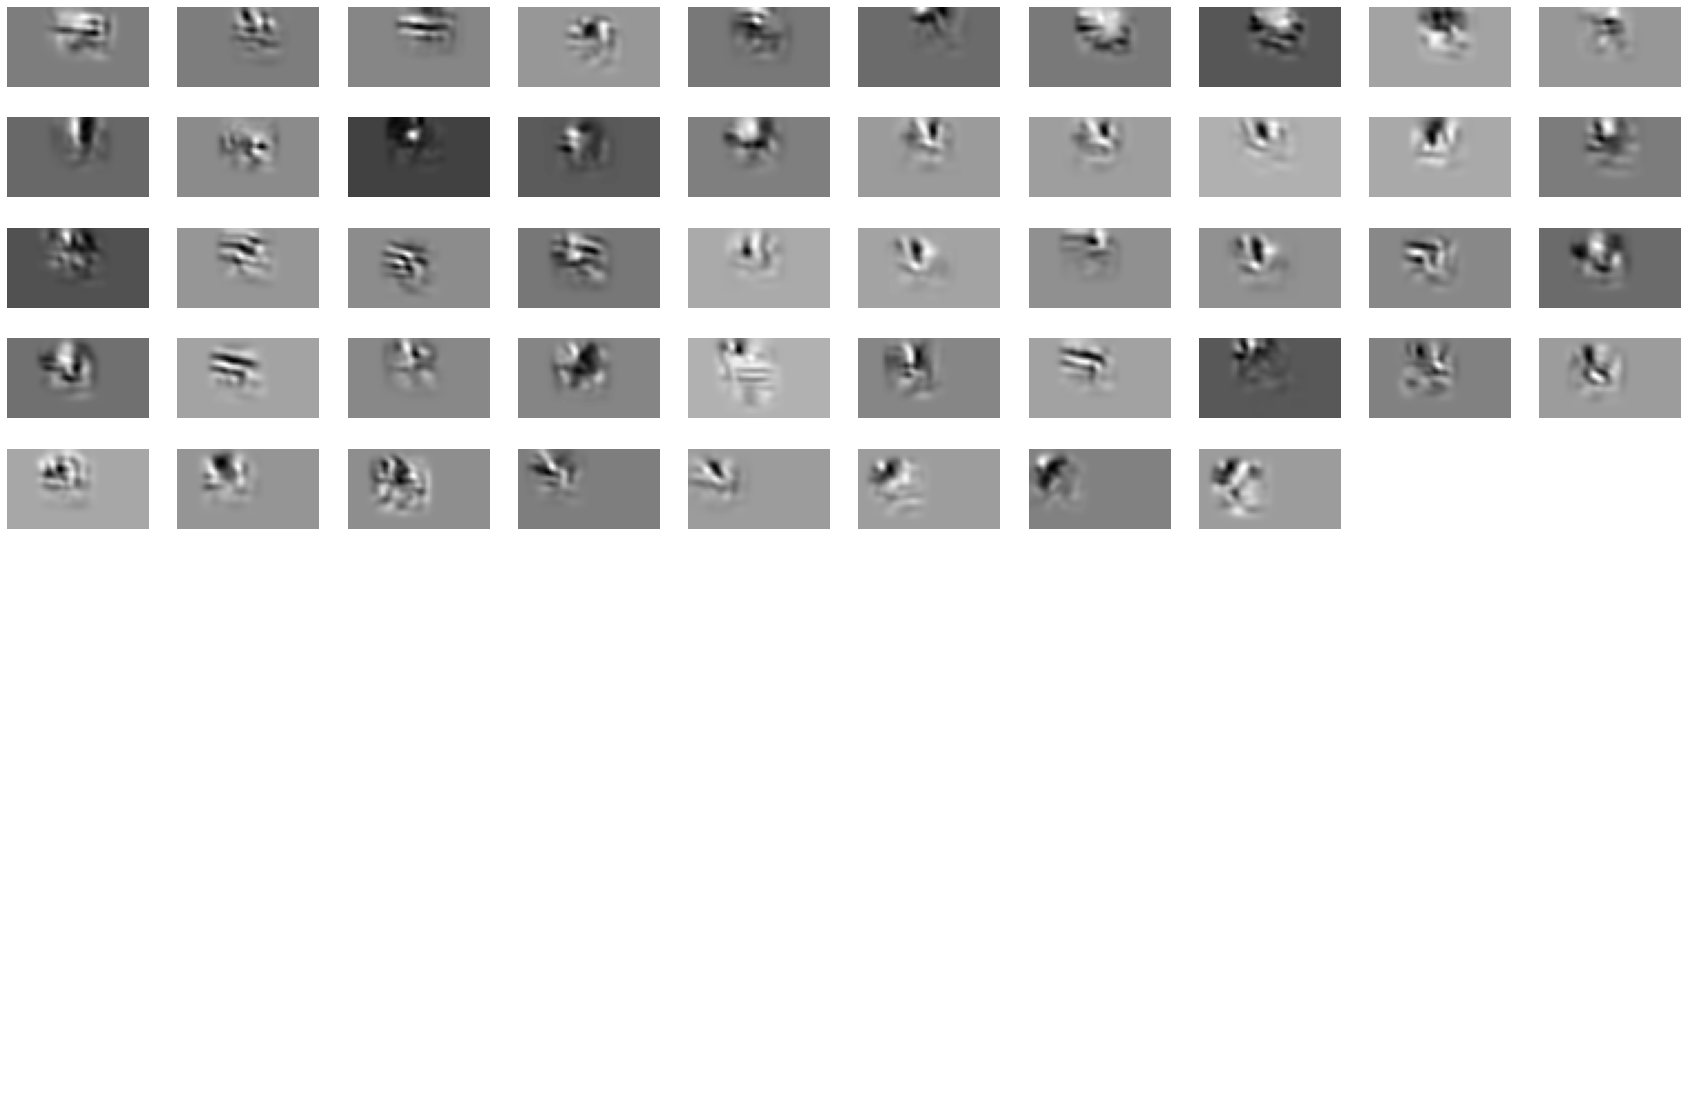

In [38]:
fig, axs = plt.subplots(10,10, figsize=(30,20))
for i, ax in enumerate(axs.ravel()):
    if i < len(MEIs):
        ax.imshow(MEIs[i], cmap="gray")
    ax.axis("off")

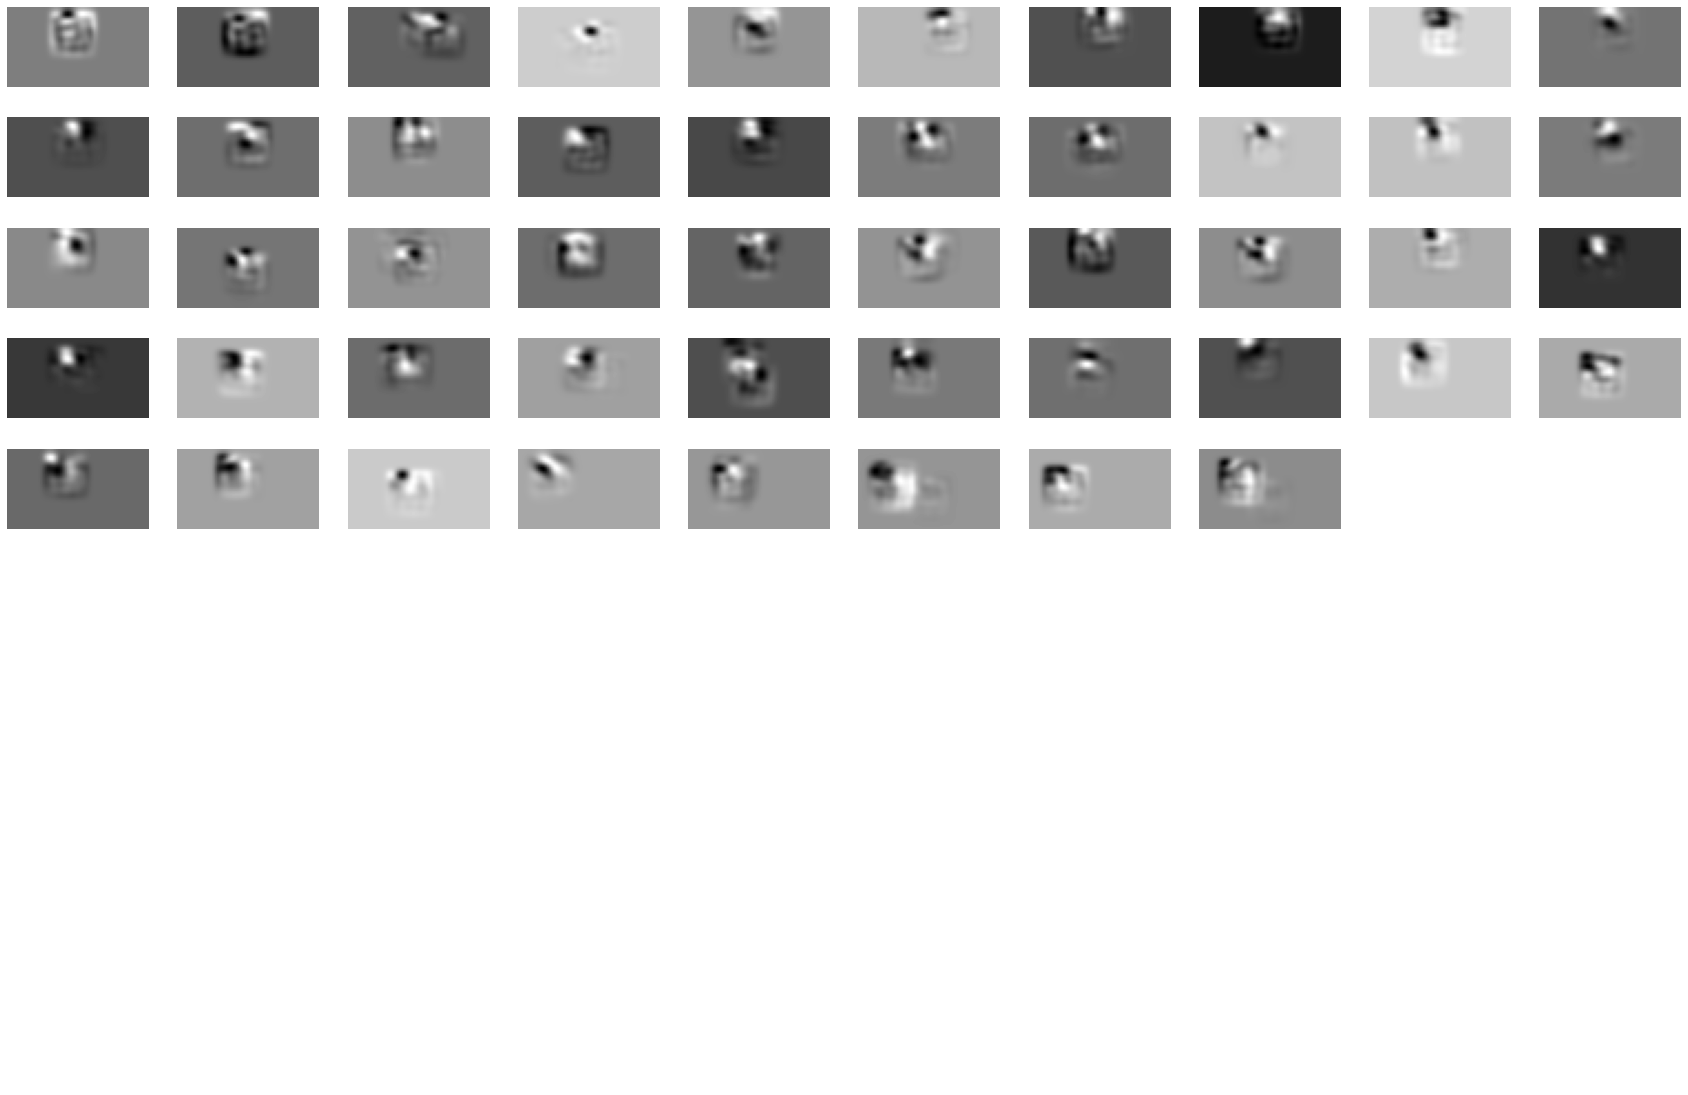

In [39]:
fig, axs = plt.subplots(10,10, figsize=(30,20))
for i, ax in enumerate(axs.ravel()):
    if i < len(ln_MEIs):
        ax.imshow(ln_MEIs[i], cmap="gray")
    ax.axis("off")

# Inserting the MEIs in tables

In [40]:
mei_keys = mei_dict
key = []
for i in range(len(mei_keys)):
    key.append(dict(image_class=mei_class, image_id=mei_keys[i]['image_id'], dataset_hash=mei_keys[0]['dataset_hash'], method_hash=mei_keys[0]['method_hash'], ensemble_hash=mei_keys[0]['ensemble_hash'],
                   data_key=mei_keys[0]['data_key'], animal_id=current_key['animal_id'], session=current_key['session'], scan_idx=current_key['scan_idx'], unit_id=mei_keys[i]['unit_id']))
    
len(key)    

48

In [41]:
stim.StaticImage.Image & {'image_class': ln_mei_class,}

image_class,image_id image id,image actual image
npx_ln_mei,0,=BLOB=
npx_ln_mei,1,=BLOB=
npx_ln_mei,2,=BLOB=
npx_ln_mei,3,=BLOB=
npx_ln_mei,4,=BLOB=
npx_ln_mei,5,=BLOB=
npx_ln_mei,6,=BLOB=
npx_ln_mei,7,=BLOB=
npx_ln_mei,8,=BLOB=
npx_ln_mei,9,=BLOB=


In [42]:
ln_mei_keys = ln_mei_dict
ln_key = []
for i in range(len(ln_mei_keys)):
    ln_key.append(dict(image_class=ln_mei_class, image_id=ln_mei_keys[i]['image_id'], dataset_hash=ln_mei_keys[0]['dataset_hash'], method_hash=ln_mei_keys[0]['method_hash'], ensemble_hash=ln_mei_keys[0]['ensemble_hash'],
                   data_key=ln_mei_keys[0]['data_key'], animal_id=current_key['animal_id'], session=current_key['session'], scan_idx=current_key['scan_idx'], unit_id=ln_mei_keys[i]['unit_id']))
    
len(ln_key)    

48

In [43]:
ln_key

[{'image_class': 'npx_ln_mei',
  'image_id': 208,
  'dataset_hash': '17a917c720720314835865d32cac93f3',
  'method_hash': '8c7de77acabedc9479aa207d8e914e9d',
  'ensemble_hash': '1a3577a497b19ae3a45a35442397cf3a',
  'data_key': '28470-13-1',
  'animal_id': 28470,
  'session': 13,
  'scan_idx': 1,
  'unit_id': 43},
 {'image_class': 'npx_ln_mei',
  'image_id': 209,
  'dataset_hash': '17a917c720720314835865d32cac93f3',
  'method_hash': '8c7de77acabedc9479aa207d8e914e9d',
  'ensemble_hash': '1a3577a497b19ae3a45a35442397cf3a',
  'data_key': '28470-13-1',
  'animal_id': 28470,
  'session': 13,
  'scan_idx': 1,
  'unit_id': 51},
 {'image_class': 'npx_ln_mei',
  'image_id': 210,
  'dataset_hash': '17a917c720720314835865d32cac93f3',
  'method_hash': '8c7de77acabedc9479aa207d8e914e9d',
  'ensemble_hash': '1a3577a497b19ae3a45a35442397cf3a',
  'data_key': '28470-13-1',
  'animal_id': 28470,
  'session': 13,
  'scan_idx': 1,
  'unit_id': 85},
 {'image_class': 'npx_ln_mei',
  'image_id': 211,
  'datas

### populate the StaticImage.NpxMEI table where the conf file will read from

In [44]:
stim.StaticImage.NpxMEI().insert(key)

In [45]:
stim.StaticImage.NpxMEI().insert(ln_key)

In [46]:
stim.StaticImage.NpxMEI() & dict(dataset_hash = mei_keys[0]['dataset_hash'])

image_class,image_id image id,"dataset_hash dataset hash from nndichromacy, identifies dataset","method_hash method hash from nndichromacy, defining mei generation (e.g. channels optimized)","ensemble_hash ensemble hash from nndichromacy, identifies ensemble model","data_key data_key from nndichromacy, unique session identifier within the model",animal_id animal id,session session,scan_idx scan index,unit_id unit id from nndichromacy
npx_ln_mei,208,17a917c720720314835865d32cac93f3,8c7de77acabedc9479aa207d8e914e9d,1a3577a497b19ae3a45a35442397cf3a,28470-13-1,28470,13,1,43
npx_ln_mei,209,17a917c720720314835865d32cac93f3,8c7de77acabedc9479aa207d8e914e9d,1a3577a497b19ae3a45a35442397cf3a,28470-13-1,28470,13,1,51
npx_ln_mei,210,17a917c720720314835865d32cac93f3,8c7de77acabedc9479aa207d8e914e9d,1a3577a497b19ae3a45a35442397cf3a,28470-13-1,28470,13,1,85
npx_ln_mei,211,17a917c720720314835865d32cac93f3,8c7de77acabedc9479aa207d8e914e9d,1a3577a497b19ae3a45a35442397cf3a,28470-13-1,28470,13,1,102
npx_ln_mei,212,17a917c720720314835865d32cac93f3,8c7de77acabedc9479aa207d8e914e9d,1a3577a497b19ae3a45a35442397cf3a,28470-13-1,28470,13,1,106
npx_ln_mei,213,17a917c720720314835865d32cac93f3,8c7de77acabedc9479aa207d8e914e9d,1a3577a497b19ae3a45a35442397cf3a,28470-13-1,28470,13,1,107
npx_ln_mei,214,17a917c720720314835865d32cac93f3,8c7de77acabedc9479aa207d8e914e9d,1a3577a497b19ae3a45a35442397cf3a,28470-13-1,28470,13,1,111
npx_ln_mei,215,17a917c720720314835865d32cac93f3,8c7de77acabedc9479aa207d8e914e9d,1a3577a497b19ae3a45a35442397cf3a,28470-13-1,28470,13,1,116
npx_ln_mei,216,17a917c720720314835865d32cac93f3,8c7de77acabedc9479aa207d8e914e9d,1a3577a497b19ae3a45a35442397cf3a,28470-13-1,28470,13,1,120
npx_ln_mei,217,17a917c720720314835865d32cac93f3,8c7de77acabedc9479aa207d8e914e9d,1a3577a497b19ae3a45a35442397cf3a,28470-13-1,28470,13,1,126


### Populate TargetStaticNpx to run the closed loop, this table should only have the entries that correspond to the images that should be shown in the current closed loop recording! 
### delete previous every time!

In [47]:
(stim.TargetStaticNpx() ) #& 'ensemble_hash = "a4a8dae1551b4b9079039849f40e207a"').delete()

"dataset_hash dataset hash from nndichromacy, identifies dataset","method_hash method hash from nndichromacy, defining mei generation (e.g. channels optimized)","ensemble_hash ensemble hash from nndichromacy, identifies ensemble model","data_key data_key from nndichromacy, unique session identifier within the model"


In [25]:
#(stim.TargetStaticNpx() & 'dataset_hash = "97abf77dd9cf4adfe2772ad384abffe5"').delete()

About to delete:
`pipeline_stimulus`.`target_static_npx`: 2 items


Proceed? [yes, No]:  yes


Committed.


In [48]:
stim.TargetStaticNpx().insert1(dict(dataset_hash=mei_keys[0]['dataset_hash'], method_hash=mei_keys[0]['method_hash'], ensemble_hash=mei_keys[0]['ensemble_hash'], data_key=mei_keys[0]['data_key']))

In [49]:
stim.TargetStaticNpx().insert1(dict(dataset_hash=ln_mei_keys[0]['dataset_hash'], method_hash=ln_mei_keys[0]['method_hash'], ensemble_hash=ln_mei_keys[0]['ensemble_hash'], data_key=ln_mei_keys[0]['data_key']))

In [62]:
(stim.TargetStaticNpx() * stim.StaticImage.NpxMEI()) * stim.StaticImage.Image()

"dataset_hash dataset hash from nndichromacy, identifies dataset","method_hash method hash from nndichromacy, defining mei generation (e.g. channels optimized)","ensemble_hash ensemble hash from nndichromacy, identifies ensemble model","data_key data_key from nndichromacy, unique session identifier within the model",image_class,image_id image id,animal_id animal id,session session,scan_idx scan index,unit_id unit id from nndichromacy,image actual image
fbd62a4219f0f708ea02e7b397141500,8c7de77acabedc9479aa207d8e914e9d,662ab97e43bec401347986bd5063f8f5,28489-16-1,npx_ln_mei,0,28489,16,1,61,=BLOB=
fbd62a4219f0f708ea02e7b397141500,8c7de77acabedc9479aa207d8e914e9d,662ab97e43bec401347986bd5063f8f5,28489-16-1,npx_ln_mei,1,28489,16,1,70,=BLOB=
fbd62a4219f0f708ea02e7b397141500,8c7de77acabedc9479aa207d8e914e9d,662ab97e43bec401347986bd5063f8f5,28489-16-1,npx_ln_mei,2,28489,16,1,71,=BLOB=
fbd62a4219f0f708ea02e7b397141500,8c7de77acabedc9479aa207d8e914e9d,662ab97e43bec401347986bd5063f8f5,28489-16-1,npx_ln_mei,3,28489,16,1,85,=BLOB=
fbd62a4219f0f708ea02e7b397141500,8c7de77acabedc9479aa207d8e914e9d,662ab97e43bec401347986bd5063f8f5,28489-16-1,npx_ln_mei,4,28489,16,1,91,=BLOB=
fbd62a4219f0f708ea02e7b397141500,8c7de77acabedc9479aa207d8e914e9d,662ab97e43bec401347986bd5063f8f5,28489-16-1,npx_ln_mei,5,28489,16,1,93,=BLOB=
fbd62a4219f0f708ea02e7b397141500,8c7de77acabedc9479aa207d8e914e9d,662ab97e43bec401347986bd5063f8f5,28489-16-1,npx_ln_mei,6,28489,16,1,95,=BLOB=
fbd62a4219f0f708ea02e7b397141500,8c7de77acabedc9479aa207d8e914e9d,662ab97e43bec401347986bd5063f8f5,28489-16-1,npx_ln_mei,7,28489,16,1,97,=BLOB=
fbd62a4219f0f708ea02e7b397141500,8c7de77acabedc9479aa207d8e914e9d,662ab97e43bec401347986bd5063f8f5,28489-16-1,npx_ln_mei,8,28489,16,1,98,=BLOB=
fbd62a4219f0f708ea02e7b397141500,8c7de77acabedc9479aa207d8e914e9d,662ab97e43bec401347986bd5063f8f5,28489-16-1,npx_ln_mei,9,28489,16,1,104,=BLOB=


# Saving the MEI dictionary as pickle file

In [141]:
open_file = open("29_neuropix_keys.pkl", "wb")
pickle.dump(mei_dict, open_file)
open_file.close()

In [144]:
open_file = open("29_neuropix_keys.pkl", "rb")
mei_keys = pickle.load(open_file)
open_file.close()

In [49]:
experiment.VisProtocol() & 'username ="maria"'

vis_protocol,username,stim_version,vis_filename,discription,timestamp
DotMapFineLonger,maria,2,/mnt/lab/users/Manolis/stim2_conf/singledotfinelonger.m,"200ms dots, blanked in between, 10x10 grid",None
ImageNet,maria,2,/home/atlab/cajal/stimuli/matlab/conf/imagenet.m,"ImageNet stimuli (5000 images, 100 oracle)",2019-09-01 06:18:23
imagenet_npx,maria,1,/mnt/lab/users/Maria/imagenet_npx.m,imagenet for neuropixels,None
NpxMEI_ClosedLoop,maria,1,/home/atlab/cajal/stimuli/matlab/conf/NpxMEI_ClosedLoop.m,closed loop for neuropixels,2022-03-29 17:11:38
